In [203]:
#增加交叉特征
#Score: Score: 0.89048
#使用5折交叉验证,增加scale_pos_weight参数
#Score: Score: 0.89292
#增加G/L
#Score: 0.88696
#交叉特征增加location_type，不使用G/L
#Score: 0.88777
#增加incident_location_type、incident_location_street、policy_bind_date_year&auto_year_diff、incident_date_year&auto_year_diff、duration、出险情况2、出险车信息
#Score: 0.88804
#使用insured_zip，训练使用earlystop，LGBM
#Score: 0.89861
#使用insured_zip, 7折lgbm
#Score: 0.88845
#调整'colsample_bytree': 0.8，7折lgbm
#Score:0.88370

#lgbm
#train、test合并一起做QuantileTransformer变换
#Score: 0.89997
#train、test不合并做QuantileTransformer变换，先做train的fit_trans，在做test的trans
#Score: 0.89428

#K折lgbm
#做QuantileTransformer变换
#Score: 0.88370
#'colsample_bytree': 1
#Score: 0.89712
#train、test不合并做QuantileTransformer变换，先做train的fit_trans，在做test的trans
#Score: 0.88899

In [204]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib # 注意这个也要import一次
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, mean_squared_error, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [205]:
#数据加载
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [206]:
datas = pd.concat((train_data, test_data))
datas.reset_index(drop=True, inplace=True)

## 数据探索

In [207]:
cat_columns = datas.select_dtypes(include=['O']).columns
numerical_columns = datas.select_dtypes(exclude=['O']).columns

In [208]:
col_name = []
unique_value = []
for col in cat_columns:
    # print(col, datas[col].nunique())
    col_name.append(col)
    unique_value.append(datas[col].nunique())

df_cat_col_unique = pd.DataFrame()
df_cat_col_unique['col_name'] = col_name
df_cat_col_unique['unique_value'] = unique_value
df_cat_col_unique = df_cat_col_unique.sort_values('unique_value', ascending= False)
# df_cat_col_unique

In [209]:
col_name = []
unique_value = []
for col in numerical_columns:
    # print(col, datas[col].nunique())
    col_name.append(col)
    unique_value.append(datas[col].nunique())

df_numerical_col_unique = pd.DataFrame()
df_numerical_col_unique['col_name'] = col_name
df_numerical_col_unique['unique_value'] = unique_value
df_numerical_col_unique = df_numerical_col_unique.sort_values('unique_value', ascending= False)
# df_numerical_col_unique

In [210]:
# df_cat_col_unique
df_numerical_col_unique

,col_name,unique_value
0,policy_id,1000
6,insured_zip,999
4,policy_annual_premium,996
16,vehicle_claim,991
13,total_claim_amount,989
14,injury_claim,945
15,property_claim,931
8,capital-loss,525
7,capital-gains,490
2,customer_months,385


## 特征工程

#### 标签编码 policy_bind_date、incident_date

In [211]:
datas['policy_bind_date'] = pd.to_datetime(datas['policy_bind_date'])
datas['incident_date'] = pd.to_datetime(datas['incident_date'])

In [212]:
#时间多尺度
datas['policy_bind_date_year'] = datas['policy_bind_date'].dt.year
datas['policy_bind_date_month'] = datas['policy_bind_date'].dt.month
datas['policy_bind_date_day'] = datas['policy_bind_date'].dt.day
datas['policy_bind_date_weekday'] = datas['policy_bind_date'].dt.weekday

datas['incident_date_year'] = datas['incident_date'].dt.year
datas['incident_date_month'] = datas['incident_date'].dt.month
datas['incident_date_day'] = datas['incident_date'].dt.day
datas['incident_date_weekday'] = datas['incident_date'].dt.weekday

In [213]:
# 查看最小、最大日期
# datas.policy_bind_date.min() #1990-01-08
# datas.policy_bind_date.max() #2015-02-22

# datas.incident_date.min() #2015-01-01
# datas.incident_date.max() #2015-03-01

In [214]:
base_date = datas.policy_bind_date.min()
#转换为diff
datas['policy_bind_date_diff'] = (datas['policy_bind_date'] - base_date).dt.days
datas['incident_date_diff'] = (datas['incident_date'] - base_date).dt.days
datas['incident_date&policy_bind_date_diff'] = datas['incident_date_diff'] - datas['policy_bind_date_diff']

#### 构造交叉业务特征

In [215]:
datas['injury_claim_pct'] = datas['injury_claim']/datas['total_claim_amount']
datas['property_claim_pct'] = datas['property_claim']/datas['total_claim_amount']
datas['vehicle_claim_pct'] = datas['vehicle_claim']/datas['total_claim_amount']

In [216]:
datas['is_injury_claim'] = datas['injury_claim'].apply(lambda x: '1' if x >0 else '0')
datas['is_property_claim'] = datas['property_claim'].apply(lambda x: '1' if x >0 else '0')
datas['is_vehicle_claim'] = datas['vehicle_claim'].apply(lambda x: '1' if x >0 else '0')

In [217]:
#出险情况1
datas['incident_type_&_is_injury_claim'] = datas['incident_type'] + '_' + datas['is_injury_claim']
datas['incident_type_&_is_property_claim'] = datas['incident_type'] + '_' + datas['is_property_claim']
datas['incident_type_&_is_vehicle_claim'] = datas['incident_type'] + '_' + datas['is_vehicle_claim']

datas['collision_type_&_is_injury_claim'] = datas['collision_type'] + '_' + datas['is_injury_claim']
datas['collision_type_&_is_property_claim'] = datas['collision_type'] + '_' + datas['is_property_claim']
datas['collision_type_&_is_vehicle_claim'] = datas['collision_type'] + '_' + datas['is_vehicle_claim']

In [218]:
datas['umbrella_limit_2_total_claim_amount'] = datas['umbrella_limit']/datas['total_claim_amount']

In [219]:
# datas['G/L'] = datas['capital-gains'] + datas['capital-loss']

In [220]:
datas['incident_location_type'] = datas['incident_city'].apply(lambda x: x.split()[-1])
datas['incident_location_street'] = datas['incident_city'].apply(lambda x: ' '.join(x.split()[-2:]))
#incident_location

In [221]:
#购车年份与投保年份之差
datas['policy_bind_date_year&auto_year_diff'] = datas['policy_bind_date_year'] - datas['auto_year']

#购车年份与出险年份之差
datas['incident_date_year&auto_year_diff'] = datas['incident_date_year'] - datas['auto_year']

#成为客户的时长与购报后出险时长之差
datas['duration'] = round((datas['incident_date'] - datas['policy_bind_date']).dt.days/30) - datas['customer_months']
#months_as_customer

In [222]:
#出险情况2
datas['incident_type&collision_type'] = (datas['incident_type'] + "_" + datas['collision_type'])

datas['incident_type&incident_severity'] = (datas['incident_type'] + "_" + datas['incident_severity'])
datas['collision_type&incident_severity'] = (datas['collision_type'] + "_" + datas['incident_severity'])

datas['incident_type&bodily_injuries'] = (datas['incident_type'] + "_" + datas['bodily_injuries'].apply(lambda x : str(x)))
datas['collision_type&bodily_injuries'] = (datas['collision_type'] + "_" + datas['bodily_injuries'].apply(lambda x : str(x)))

datas['incident_type&property_damage'] = (datas['incident_type'] + "_" + datas['property_damage'])
datas['collision_type&property_damage'] = (datas['collision_type'] + "_" + datas['property_damage'])

datas['incident_type&collision_type&incident_severity&bodily_injuries&property_damage'] = (datas['incident_type'] + "_" + datas['collision_type'] + "_" + datas['incident_severity'] 
 + "_" + datas['bodily_injuries'].apply(lambda x : str(x)) + "_" + datas['property_damage'])

In [223]:
#出险车信息
datas['auto_make&auto_model'] = datas['auto_make'] + "_" + datas['auto_model']

In [224]:
# datas[['incident_type', 'collision_type', 'bodily_injuries', 'incident_severity', 'property_damage', 'policy_csl', 'policy_annual_premium', 'umbrella_limit', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'capital-gains', 'capital-loss']][datas['fraud_reported'] > 0]

In [225]:
#检查单个特征
# datas.property_damage.nunique()
# datas['property_damage'].value_counts()

In [226]:
datas.drop(['policy_bind_date', 'incident_date',  'incident_city', 'policy_id', 'auto_make', 'auto_model'], axis= 1, inplace=True)
#下次保留insured_zip试试
#['_c39', 'incident_location', 'policy_number']

In [227]:
numerical_columns = datas.select_dtypes(exclude=['O']).columns
cat_columns = datas.select_dtypes(include=['O']).columns

In [228]:
numerical_columns = numerical_columns.delete(numerical_columns.get_loc('fraud'))
#fraud_reported

In [229]:
import math

In [230]:
df_melted = pd.melt(datas[numerical_columns].join(pd.DataFrame(['Train' if not math.isnan(label) else 'Test' 
                                                                for label in datas['fraud']], index=datas.index, columns=['Source'])
                                                  , how='left'), id_vars= ['Source'],
                    )
#fraud_reported

In [231]:
numerical_columns

Index(['age', 'customer_months', 'policy_deductable', 'policy_annual_premium',
       'umbrella_limit', 'insured_zip', 'capital-gains', 'capital-loss',
       'incident_hour_of_the_day', 'number_of_vehicles_involved',
       'bodily_injuries', 'witnesses', 'total_claim_amount', 'injury_claim',
       'property_claim', 'vehicle_claim', 'auto_year', 'policy_bind_date_year',
       'policy_bind_date_month', 'policy_bind_date_day',
       'policy_bind_date_weekday', 'incident_date_year', 'incident_date_month',
       'incident_date_day', 'incident_date_weekday', 'policy_bind_date_diff',
       'incident_date_diff', 'incident_date&policy_bind_date_diff',
       'injury_claim_pct', 'property_claim_pct', 'vehicle_claim_pct',
       'umbrella_limit_2_total_claim_amount',
       'policy_bind_date_year&auto_year_diff',
       'incident_date_year&auto_year_diff', 'duration'],
      dtype='object')

<Axes: xlabel='capital-gains', ylabel='Density'>

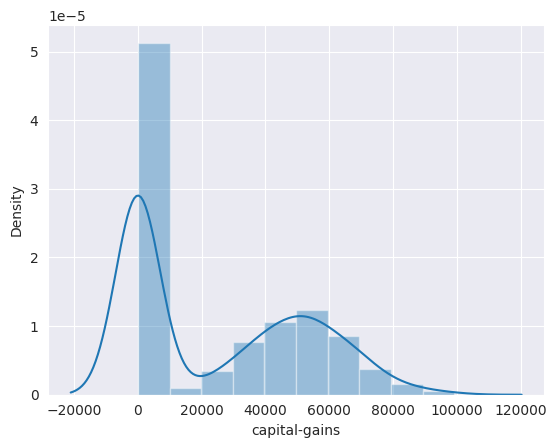

In [232]:
sns.distplot(datas['capital-gains'])

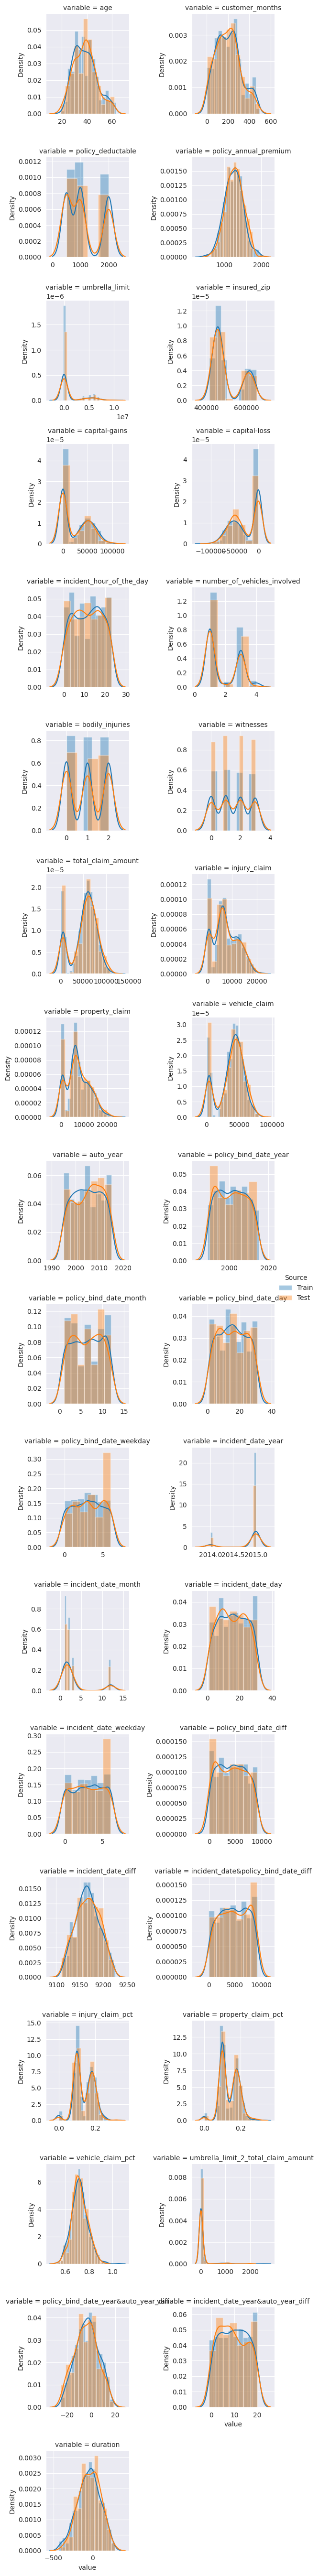

In [233]:
#画出各特征的分布图

g = sns.FacetGrid(df_melted, hue = 'Source', col='variable', col_wrap= 2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
g.add_legend()

In [234]:
from sklearn.preprocessing import QuantileTransformer

In [235]:
# 数据集切分
train = datas[datas['fraud'].notnull()]
test = datas[datas['fraud'].isnull()]
#fraud_reported

In [236]:
quantile_transformer = QuantileTransformer(output_distribution='normal', random_state = 2022)
# datas[numerical_columns] = quantile_transformer.fit_transform(datas[numerical_columns])
train[numerical_columns] = quantile_transformer.fit_transform(train[numerical_columns])
test[numerical_columns] = quantile_transformer.transform(test[numerical_columns])

In [237]:
datas = pd.concat((train, test))
datas.reset_index(drop=True, inplace=True)

In [238]:
df_melted = pd.melt(datas[numerical_columns].join(pd.DataFrame(['Train' if not math.isnan(label) else 'Test' 
                                                                for label in datas['fraud']], index=datas.index, columns=['Source'])
                                                  , how='left'), id_vars= ['Source'],
                    )
#fraud_reported

<Axes: xlabel='capital-gains', ylabel='Density'>

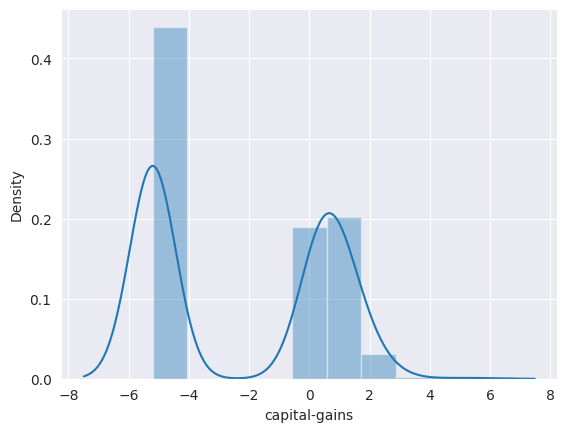

In [239]:
sns.distplot(datas['capital-gains'])

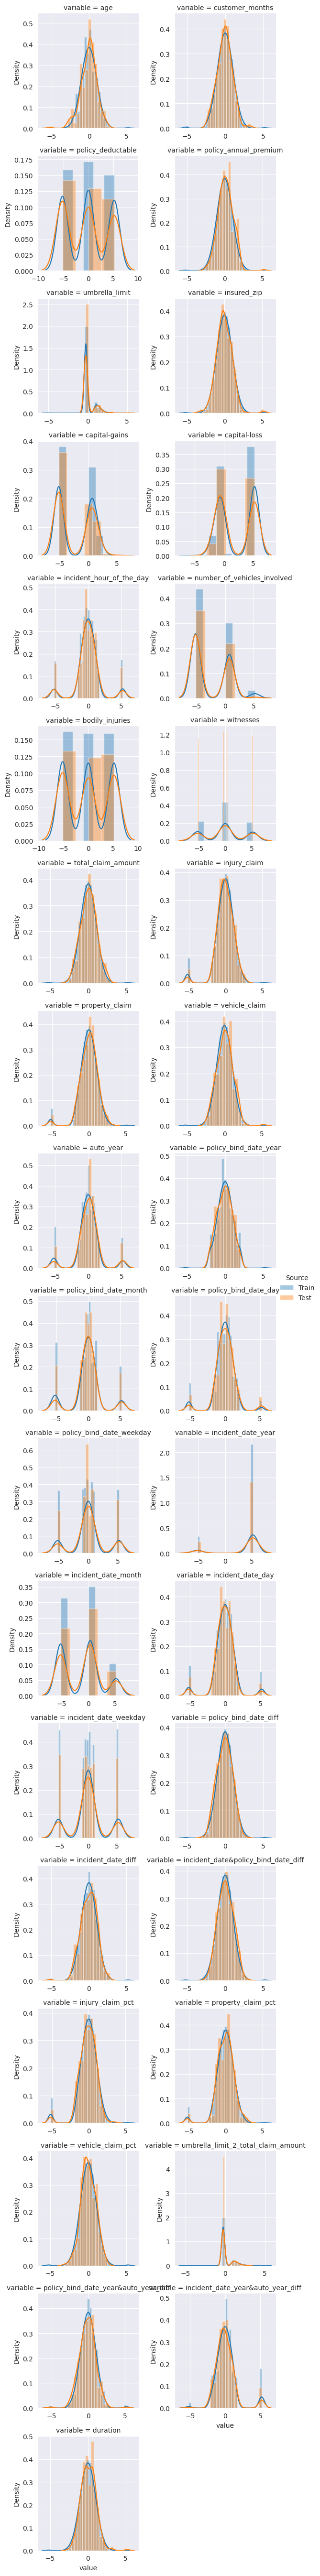

In [240]:
#画出各特征的分布图

g = sns.FacetGrid(df_melted, hue = 'Source', col='variable', col_wrap= 2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")
g.add_legend()

In [182]:
from sklearn.preprocessing import LabelEncoder

In [183]:
cat_columns = datas.select_dtypes(include= ['O']).columns

In [184]:
for col in cat_columns:
    le = LabelEncoder()
    datas[col] = le.fit_transform(datas[col])

datas[cat_columns]

,policy_state,policy_csl,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,incident_type,collision_type,incident_severity,...,incident_location_street,incident_type&collision_type,incident_type&incident_severity,collision_type&incident_severity,incident_type&bodily_injuries,collision_type&bodily_injuries,incident_type&property_damage,collision_type&property_damage,incident_type&collision_type&incident_severity&bodily_injuries&property_damage,auto_make&auto_model
0,2,2,0,5,10,15,1,2,3,2,...,5,6,7,10,6,9,6,9,170,25
1,1,1,1,3,2,14,2,0,3,1,...,6,2,1,9,2,11,0,9,69,19
2,1,2,0,2,6,16,5,2,3,2,...,3,6,7,10,8,11,6,9,176,21
3,0,2,1,3,13,18,3,0,1,0,...,3,0,0,2,2,5,2,5,8,33
4,0,0,0,4,2,18,3,0,2,2,...,3,1,2,7,2,8,2,8,53,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,2,0,1,9,11,1,1,0,3,...,0,3,4,1,3,0,4,1,91,12
996,2,1,1,4,0,12,4,0,3,2,...,1,2,2,10,0,9,0,9,72,20
997,2,2,0,0,7,10,1,2,2,1,...,2,5,6,6,6,6,8,8,136,13
998,2,0,0,4,10,10,4,0,3,1,...,6,2,1,9,2,11,2,11,71,25


In [185]:
# 数据集切分
train = datas[datas['fraud'].notnull()]
test = datas[datas['fraud'].isnull()]
#fraud_reported

In [186]:
train_X = train.drop(['fraud'], axis=1)
train_y = train['fraud']
test_X = test.drop(['fraud'], axis=1)
#fraud_reported

In [187]:
#增加检验
train_X2,eval_X,train_y2,eval_y = train_test_split(train_X, train_y, test_size=0.2, random_state=2022, stratify=train_y)

## 使用lgbm 训练

In [188]:
import lightgbm as lgb

In [189]:
model_lgb = lgb.LGBMClassifier(
           device='gpu', num_leaves=2**5-1, reg_alpha=0.25, reg_lambda=0.25, objective='binary', metric = 'binary_logloss,auc',
            max_depth=-1, learning_rate=0.005, min_child_samples=3, random_state=2022,
            n_estimators=2000, subsample=1, colsample_bytree=1,
        )

In [190]:
model_lgb.fit(train_X2, train_y2, eval_set=(eval_X, eval_y), categorical_feature = cat_columns.values.tolist())
              #early_stopping_rounds = 400)
#TODO:此处有更改

[LightGBM] [Info] Number of positive: 145, number of negative: 415
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3428
[LightGBM] [Info] Number of data points in the train set: 560, number of used features: 68
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 63 dense feature groups (0.03 MB) transferred to GPU in 0.004061 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.258929 -> initscore=-1.051545
[LightGBM] [Info] Start training from score -1.051545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

LGBMClassifier(colsample_bytree=1, device='gpu', learning_rate=0.005,
               metric='binary_logloss,auc', min_child_samples=3,
               n_estimators=2000, objective='binary', random_state=2022,
               reg_alpha=0.25, reg_lambda=0.25, subsample=1)

In [191]:
y_pred = model_lgb.predict_proba(test_X )[:, 1]

#检验
# y_pred = model_lgb.predict_proba(eval_X)[:, 1]

In [192]:
y_pred

array([1.39590725e-01, 8.60469368e-01, 1.69248396e-03, 4.15274307e-02,
       1.47052267e-02, 2.38365088e-02, 7.89301378e-02, 3.59262786e-03,
       1.62291941e-03, 5.33433789e-03, 1.66653645e-02, 6.17469993e-04,
       7.33251942e-01, 1.54155086e-02, 1.66388364e-03, 2.55509096e-01,
       9.13144858e-03, 5.95158504e-03, 8.96217683e-01, 1.32310720e-02,
       3.23376860e-03, 1.54720669e-01, 9.65501731e-01, 4.88729259e-03,
       3.78437437e-02, 7.78146571e-01, 6.82673252e-02, 1.20658544e-02,
       4.52322092e-01, 2.11215816e-02, 4.61172571e-01, 3.06560710e-02,
       9.59138839e-01, 1.26109819e-02, 3.07163165e-03, 1.78038540e-03,
       4.92849240e-01, 1.22002628e-02, 4.46726714e-03, 1.31431747e-02,
       7.39570952e-01, 6.36539365e-03, 7.40900984e-03, 3.27397679e-03,
       2.75848564e-02, 1.90131260e-02, 8.17926187e-03, 1.64376369e-02,
       3.54798675e-01, 2.33900811e-03, 1.60023097e-01, 1.88462173e-02,
       6.99301310e-04, 4.41241017e-01, 3.69366309e-01, 7.08650531e-02,
      

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

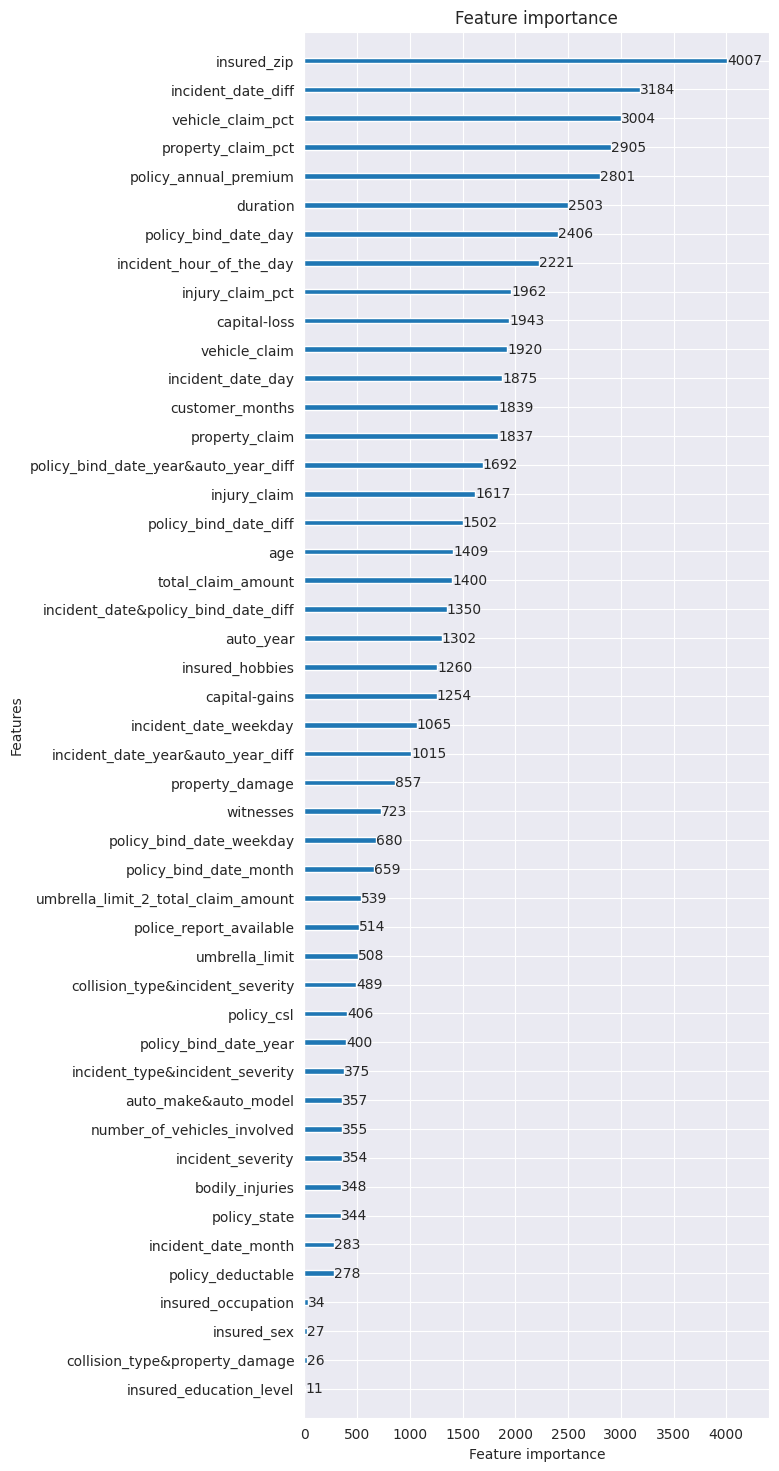

In [193]:
fig, ax = plt.subplots(figsize=(6,18))
lgb.plot_importance(model_lgb, max_num_features=70, ax = ax)

In [194]:
#检验
# roc_auc_score(eval_y, y_pred)

In [195]:
submission = pd.read_csv('./data/sampleSubmission.csv')
submission['fraud_reported'] = y_pred
submission.to_csv('./submission/submission.csv', index=None)

## 使用五折交叉验证的LightGBM

In [196]:
from sklearn.model_selection import StratifiedKFold, KFold
import lightgbm as lgb

In [197]:
params_lgb = {
    'num_leaves': 2**5-1, 'reg_alpha': 0.25, 'reg_lambda': 0.25, 'objective': 'binary', 'metric': 'binary_logloss,auc',
    'max_depth': -1, 'learning_rate': 0.001, 'min_child_samples': 3, 'random_state': 2022,
    #'n_estimators': 2000, 
    'subsample': 1, 'colsample_bytree': 1, #'scale_pos_weight': 3
    'device': 'gpu' , # 启用 GPU
}

In [198]:
NFOLD = 7

In [199]:
kf = StratifiedKFold(n_splits = NFOLD, shuffle = True, random_state = 2022)

y_pred = np.zeros(len(test_X))

#检验
# y_pred = np.zeros(len(eval_X))

In [200]:
mean_valscore = []
for fold, (train_index, val_index) in enumerate(kf.split(train_X, train_y)):
    X_fold_train, X_fold_val = train_X.iloc[train_index, :], train_X.iloc[val_index, :]
    y_fold_train, y_fold_val = train_y.iloc[train_index], train_y.iloc[val_index]
    train_set = lgb.Dataset(X_fold_train, y_fold_train)
    val_set = lgb.Dataset(X_fold_val, y_fold_val, reference=train_set)

    model_lgb = lgb.train(params_lgb, train_set, num_boost_round=2000, #early_stopping_rounds=500,
                      valid_sets = val_set)#, verbose_eval=100)
    
    mean_valscore.append(model_lgb.best_score['valid_0']['auc'])

    y_pred += model_lgb.predict(test_X)/kf.n_splits
    
print('valscore:', mean_valscore)
print('mean_valscore:', np.mean(mean_valscore))
    
    #检验
#     y_pred += model_lgb.predict(eval_X, num_iteration=model_lgb.best_iteration)/kf.n_splits

# y_pred = [1 if y > 0.5 else 0 for y in y_pred]
# rmse = metrics.accuracy_score(y_pred,y_test)
# print(rmse)
#TODO:注释处有更改变

[LightGBM] [Info] Number of positive: 156, number of negative: 444
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3611
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 68
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3090 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 63 dense feature groups (0.04 MB) transferred to GPU in 0.004362 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.260000 -> initscore=-1.045969
[LightGBM] [Info] Start training from score -1.045969
[LightGBM] [Info] Number of positive: 155, number of negative: 445
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 3620
[LightGBM] [Info] Number of data points in the train set: 600, number of used features: 68
[LightGBM] [Info] Using GPU Device:

In [ ]:
#检验
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(eval_y, y_pred)
print(f'ROC AUC: {roc_auc}')


In [202]:
submission = pd.read_csv('./data/sampleSubmission.csv')
submission['fraud_reported'] = y_pred
submission.to_csv('./submission/submission_Kfold.csv', index=None)